<a href="https://colab.research.google.com/github/huihuiwuwu/Github-Colab/blob/main/20231028.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from gensim import corpora
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation

import site
import re
from tqdm import tqdm

import pandas as pd
import os

In [4]:
C=pd.read_csv('/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(231026)/무역/C_token_words.csv')
K=pd.read_csv('/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(231026)/무역/K_token_words.csv')
A=pd.read_csv('/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(231026)/무역/A_token_words.csv')
Export=pd.read_csv('/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(231026)/무역/Export_token_words.csv')
Economic=pd.read_csv('/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(231026)/무역/Economic_token_words.csv')

In [9]:
Economic.head()

,Contents,ProcessedData
0,"[헤럴드경제(도하)=최은지 기자, 정윤희 기자] 윤석열 대통령은 25일(현지시간) ...","['헤럴드', '경제', '도하', '최은지', '기자', '정윤희', '기자', ..."
1,윤석열 대통령이 사우디아라비아와 카타르 국빈 순방에서 202억달러(약 27조원) 투...,"['윤석열', '대통령', '사우디아라비아', '카타르', '국빈', '순방', '..."
2,사우디아라바이와 카타르를 국빈 방문한 윤석열 대통령이 '중동 세일즈'로 총 107조...,"['사우디아', '바이', '카타르', '국빈', '방문', '윤석열', '대통령'..."
3,코트라는 윤석열 대통령의 카타르 국빈 방문에 맞춰 지난 25일 카타르 도하에서 ‘한...,"['코트', '윤석열', '대통령', '카타르', '국빈', '방문', '카타르',..."
4,[헤럴드경제=서재근 기자] 코트라(KOTRA)가 한불상공회의소와 함께 안다즈 서울 ...,"['헤럴드', '경제', '서재근', '기자', '코트', '불상', '공회', '..."


In [5]:
# 토픽 모델링
# 1. 최적의 토픽 수 계산
coherence_values = []
model_list = []

In [34]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    model_list = []
    coherence_values = []

    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, iterations=100)
        model_list.append(model)

        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [35]:
def find_optimal_number_of_topics(dictionary, corpus, processed_data, limit=8):
    start = 1
    step = 1

    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_data, start=start, limit=limit, step=step)

    x = range(start, limit, step)

    # 这里我们加一个断言以确保x和coherence_values的长度是相同的
    assert len(x) == len(coherence_values), "Length mismatch between x and coherence_values"

    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')

    dic = {coherence: num_topics for num_topics, coherence in zip(x, coherence_values)}

    plt.text(dic[max(coherence_values)], min(coherence_values), str(dic[max(coherence_values)]) + ' at MAX', color='r', horizontalalignment='center', verticalalignment='bottom')

    plt.show()

    return dic[max(coherence_values)]


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
import ast

Economic["ProcessedData"] = Economic["ProcessedData"].apply(ast.literal_eval)

dictionary = corpora.Dictionary(Economic["ProcessedData"])

corpus = [dictionary.doc2bow(text) for text in Economic["ProcessedData"]]

processed_data = Economic["ProcessedData"].tolist()

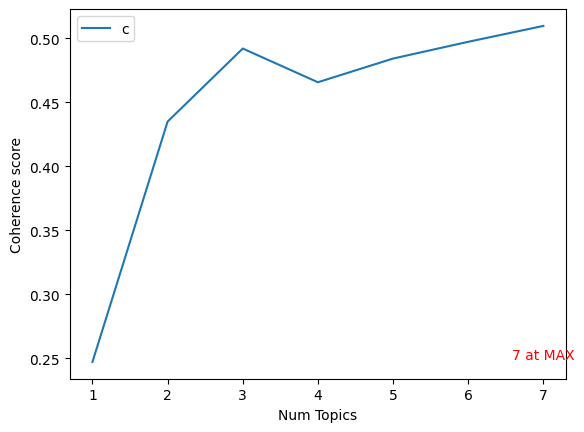

In [36]:
limit = 8
NUM_TOPICS = find_optimal_number_of_topics(dictionary, corpus, processed_data, limit)

In [39]:
Economic["ProcessedData"] = Economic["ProcessedData"].apply(' '.join)

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(Economic["ProcessedData"])

In [40]:
# LDA모델 생성
lda_model = LatentDirichletAllocation(n_components=3, learning_method='online', random_state=42, max_iter=1)
lda_top = lda_model.fit_transform(X)

In [41]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx + 1}:")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

n_top_words = 20
tf_feature_names = vectorizer.get_feature_names_out()
print_top_words(lda_model, tf_feature_names, n_top_words)


Topic #1:
수출 경제 중국 달러 무역 미국 적자 세계 반도체 전망 성장 위기 수지 경기 코로나 정부 기록 분기 기자 금리
Topic #2:
무역 기업 통상 산업 경제 한국 수출 협회 베트남 지역 개최 자원 지원 협력 시장 투자 회장 기자 정부 자유
Topic #3:
대통령 정상 중국 윤석열 주석 회담 미국 국가 러시아 시진핑 현지 총리 시간 외교 관계 바이든 회의 양국 북한 이날



In [16]:
# 단어 집합. 1,000개의 단어가 저장됨.
terms = vectorizer.get_feature_names_out()

def get_topics(components, feature_names, n=20):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n - 1:-1]])

In [17]:
Economic_topic=get_topics(lda_model.components_,terms)

Topic 1: [('기업', 172.46), ('수출', 132.41), ('무역', 132.11), ('지원', 105.65), ('산업', 91.2), ('투자', 81.42), ('시장', 80.86), ('경제', 76.91), ('해외', 76.76), ('중소기업', 75.69), ('태국', 73.99), ('지역', 67.93), ('통상', 66.75), ('한국', 64.45), ('개최', 63.86), ('디지털', 63.14), ('기관', 62.02), ('사업', 61.29), ('중소', 59.29), ('업무', 58.23)]
Topic 2: [('미국', 413.73), ('중국', 314.44), ('산업', 182.43), ('통상', 181.47), ('경제', 162.81), ('무역', 160.3), ('정부', 159.12), ('반도체', 138.23), ('일본', 136.49), ('바이든', 131.74), ('한국', 131.05), ('감축', 129.95), ('현지', 123.31), ('공급', 118.46), ('인플레이션', 118.15), ('기업', 115.31), ('대만', 113.36), ('태평양', 111.49), ('시간', 109.21), ('기자', 99.31)]
Topic 3: [('대통령', 365.55), ('정상', 270.89), ('주석', 228.45), ('회담', 185.33), ('시진핑', 180.19), ('중국', 178.61), ('윤석열', 178.15), ('국가', 166.02), ('협력', 150.56), ('총리', 137.61), ('양국', 117.21), ('회의', 111.29), ('관계', 110.49), ('포럼', 107.9), ('방문', 106.95), ('아세안', 104.21), ('현지', 98.22), ('외교', 98.18), ('이날', 97.27), ('시간', 90.05)]
Topic 4: [('수출', 491.

In [18]:
def get_topics2(components, terms):
    topics = []
    for topic_idx, topic in enumerate(components):
        topic_terms = [(terms[i], topic[i]) for i in topic.argsort()[:-30 - 1:-1]]
        topics.append((topic_idx, topic_terms))
    return topics

In [48]:
Economic_topics = get_topics2(lda_model.components_, terms)
if Economic_topics is not None:
    df = pd.DataFrame(Economic_topics, columns=['Topic', 'Terms'])
else:
    df = pd.DataFrame()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
topics_transformed = [(topic[0], word, value) for topic in Economic_topics for word, value in topic[1]]
df = pd.DataFrame(topics_transformed, columns=['Topic', 'Word', 'Value'])
df.to_csv('/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(231026)/무역/Economic_topics(3).csv',index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


* Export

In [53]:
Export=pd.read_csv('/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(231026)/무역/Export_token_words.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
import ast
Export["ProcessedData"] = Export["ProcessedData"].apply(ast.literal_eval)

dictionary = corpora.Dictionary(Export["ProcessedData"])

corpus = [dictionary.doc2bow(text) for text in Export["ProcessedData"]]

processed_data = Export["ProcessedData"].tolist()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


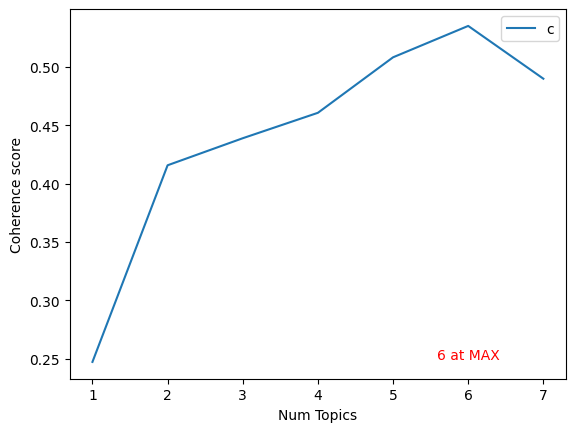

In [55]:
limit = 8
NUM_TOPICS = find_optimal_number_of_topics(dictionary, corpus, processed_data, limit)

In [57]:
# LDA모델 생성
lda_model = LatentDirichletAllocation(n_components=6, learning_method='online', random_state=42, max_iter=1)
lda_top = lda_model.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
Export_topics = get_topics2(lda_model.components_, terms)
if Export_topics is not None:
    df = pd.DataFrame(Export_topics, columns=['Topic', 'Terms'])
else:
    df = pd.DataFrame()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [59]:
topics_transformed = [(topic[0], word, value) for topic in Export_topics for word, value in topic[1]]
df = pd.DataFrame(topics_transformed, columns=['Topic', 'Word', 'Value'])
df.to_csv('/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(231026)/무역/Export_topics.csv',index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 20210101~20231026 데이터를 사용

In [61]:
folder_path = "/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028"
files=os.listdir(folder_path)
files

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['Economic1.xlsx',
 'Eport1.xlsx',
 'K1.xlsx',
 'A2.xlsx',
 'A1.xlsx',
 'C1.xlsx',
 'K2.xlsx',
 'Export2.xlsx',
 'C2.xlsx',
 'Economic2.xlsx',
 'A3.xlsx']

In [62]:
dfs = []  # 用于存储每个文件的DataFrame

for file in files:
    if file.endswith(('K1.xlsx', 'K2.xlsx')):
        file_path = os.path.join(folder_path, file)
        df = pd.read_excel(file_path)
        dfs.append(df)

merged_df = pd.concat(dfs, ignore_index=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
# merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32806 entries, 0 to 32805
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   뉴스 식별자             32806 non-null  float64
 1   일자                 32806 non-null  int64  
 2   언론사                32806 non-null  object 
 3   기고자                30709 non-null  object 
 4   제목                 32806 non-null  object 
 5   통합 분류1             32806 non-null  object 
 6   통합 분류2             28243 non-null  object 
 7   통합 분류3             20848 non-null  object 
 8   사건/사고 분류1          4695 non-null   object 
 9   사건/사고 분류2          1005 non-null   object 
 10  사건/사고 분류3          349 non-null    object 
 11  인물                 26563 non-null  object 
 12  위치                 32647 non-null  object 
 13  기관                 32795 non-null  object 
 14  키워드                32806 non-null  object 
 15  특성추출(가중치순 상위 50개)  32806 non-null  object 
 16  본문                 328

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
merged_df.to_csv("/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/K_all.csv", index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [65]:
K_all=merged_df[['본문']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [66]:
# K_all.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,본문
0,올 들어 이달 20일까지 338억4000만달러의 무역적자가 났다. 연간 기준 역대 ...
1,[앵커]\n최근 각종 악재가 겹치면서 국내 경제를 둘러싼 우려가 커지고 있습니다.\...
2,미 중 갈등이 격화하는 가운데 중국의 미국 유럽 상대 수출은 크게 감소한 반면 러시...
3,"""인플레이션(Inflation 전반적인 물가 수준 상승)에 대응하기 위해 금리를 올..."
4,'시진핑(習近平) 3기로 인한 '차이나런'의 불똥이 원화로 튀었다. 25일 원화가치...


In [67]:
K_all=K_all.rename(columns={'본문':'Contents'})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [68]:
TARGET_COL = "Contents"
PROCESSED_COL = "ProcessedData"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [69]:
K_all[PROCESSED_COL]=[False for _ in range(len(K_all[TARGET_COL]))]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
# 개행 문자 (CRLF) 제거
def remove_CRLF(input_str):
    input_str = input_str.replace("\n", " ")
    input_str = input_str.replace("\n", " ")
    input_str = input_str.replace("\r", " ")
    input_str = input_str.replace("\r", " ")

    return input_str

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [71]:
for i in range(len(K_all[TARGET_COL])):
    K_all[PROCESSED_COL][i] = remove_CRLF(K_all[TARGET_COL][i])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [72]:
# 이모티콘 문자들, 사이트 URL주소, 의미없는 문자 지우기
def cleansing(input_str):
    output_str = re.sub(pattern='<[U]\+[A-Z0-9]*>', repl=' ', string=input_str)
    output_str = re.sub(pattern='http[s]?://(?:[a-zA-Z]|[0-9]|[_$\-@\.&+:/?=]|[!*,]|(?:%[0-9a-fA-F_][0-9a-fA-F_]))+', repl=' ', string=output_str)
    output_str = re.sub(pattern='^[0-9]+$', repl=' ', string=output_str)

    return output_str

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:3: DeprecationWarning: invalid escape sequence '\+'
<>:4: DeprecationWarning: invalid escape sequence '\-'
<>:3: DeprecationWarning: invalid escape sequence '\+'
<>:4: DeprecationWarning: invalid escape sequence '\-'
<ipython-input-72-9680d50ef228>:3: DeprecationWarning: invalid escape sequence '\+'
  output_str = re.sub(pattern='<[U]\+[A-Z0-9]*>', repl=' ', string=input_str)
<ipython-input-72-9680d50ef228>:4: DeprecationWarning: invalid escape sequence '\-'
  output_str = re.sub(pattern='http[s]?://(?:[a-zA-Z]|[0-9]|[_$\-@\.&+:/?=]|[!*,]|(?:%[0-9a-fA-F_][0-9a-fA-F_]))+', repl=' ', string=output_str)


In [73]:
for i in range(len(K_all[TARGET_COL])):
    K_all[PROCESSED_COL][i] = cleansing(K_all[PROCESSED_COL][i])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [76]:
import nltk
nltk.download('punkt')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [75]:
 # 불용어 제거 단계
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
stopwords_df = pd.read_excel("/content/drive/MyDrive/졸업논문/AI Media/stopwords.xlsx")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [78]:
stop_words = set(stopwords_df['stopword'].str.lower())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [79]:
# 불용어 제거 함수 정의
def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.casefold() not in stop_words]
    return ' '.join(filtered_text)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [80]:
for i in tqdm(range(len(K_all[TARGET_COL]))):
    K_all[PROCESSED_COL][i] = remove_stopwords(K_all[PROCESSED_COL][i])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 32806/32806 [00:16<00:00, 2009.36it/s]


In [81]:
K_all.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Contents,ProcessedData
0,올 들어 이달 20일까지 338억4000만달러의 무역적자가 났다. 연간 기준 역대 ...,올 들어 이달 20일까지 338억4000만달러의 무역적자가 났다 . 연간 기준 역대...
1,[앵커]\n최근 각종 악재가 겹치면서 국내 경제를 둘러싼 우려가 커지고 있습니다.\...,"[ 앵커 ] 악재가 겹치면서 국내 경제를 둘러싼 우려가 커지고 . 국제통화기금 , ..."
2,미 중 갈등이 격화하는 가운데 중국의 미국 유럽 상대 수출은 크게 감소한 반면 러시...,미 중 갈등이 격화하는 가운데 중국의 미국 유럽 수출은 크게 감소한 반면 러시아 수...
3,"""인플레이션(Inflation 전반적인 물가 수준 상승)에 대응하기 위해 금리를 올...",`` 인플레이션 ( Inflation 전반적인 물가 수준 상승 ) 대응하기 위해 금...
4,'시진핑(習近平) 3기로 인한 '차이나런'의 불똥이 원화로 튀었다. 25일 원화가치...,'시진핑 ( 習近平 ) 3기로 인한 '차이나런 ' 불똥이 원화로 튀었다 . 25일 ...


In [82]:
K_all.to_csv('/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/K_all_remove_stopwords.csv',index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
from konlpy.tag import Mecab
mecab = Mecab()

In [84]:
# 토큰화_명사만 남기기 (*mecab.morphs를 사용해 나온 결과는 별로였어서 아래처름 mecab.nouns로 명사만 추출)
def tokenize_and_filter(text):
    tokens = mecab.nouns(text)  # 텍스트에서 명사만 추출합니다
    tokens = [token for token in tokens if len(token) > 1]  # 길이가 1보다 큰 토큰만 선택합니다
    return tokens

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [85]:
for i in tqdm(range(len(K_all[TARGET_COL]))):
    # List of strings to single string
    if isinstance(K_all[PROCESSED_COL][i], list):
        input_string = ' '.join(K_all[PROCESSED_COL][i])
    else:
        input_string = K_all[PROCESSED_COL][i]
    K_all[PROCESSED_COL][i] = tokenize_and_filter(input_string)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 32806/32806 [00:13<00:00, 2521.36it/s]


In [86]:
K_all.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Contents,ProcessedData
0,올 들어 이달 20일까지 338억4000만달러의 무역적자가 났다. 연간 기준 역대 ...,"[이달, 달러, 무역, 적자, 연간, 기준, 역대, 최대, 달러, 기록, 추세, 무..."
1,[앵커]\n최근 각종 악재가 겹치면서 국내 경제를 둘러싼 우려가 커지고 있습니다.\...,"[앵커, 악재, 국내, 경제, 우려, 국제통화기금, 경제, 기초, 체력, 문제, 성..."
2,미 중 갈등이 격화하는 가운데 중국의 미국 유럽 상대 수출은 크게 감소한 반면 러시...,"[갈등, 격화, 가운데, 중국, 미국, 유럽, 수출, 감소, 반면, 러시아, 수출,..."
3,"""인플레이션(Inflation 전반적인 물가 수준 상승)에 대응하기 위해 금리를 올...","[인플레이션, 전반, 물가, 수준, 상승, 대응, 금리, 성장, 전망, 악영향, 통..."
4,'시진핑(習近平) 3기로 인한 '차이나런'의 불똥이 원화로 튀었다. 25일 원화가치...,"[시진핑, 차이, 불똥, 원화, 원화, 가치, 장중, 연중, 최저, 추락, 미국, ..."


In [87]:
K_all.to_csv('/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/K_all_token_words.csv',index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [88]:
# 빈도수 생성
from collections import Counter

all_words = []
for text in K_all[PROCESSED_COL]:
    if isinstance(text, list): # 如果数据是list类型（如单词列表），则将其添加到all_words中
        all_words.extend(text)
    else: # 如果数据是str类型（如句子），则将其分词后添加到all_words中
        all_words.extend(text.split())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [89]:
word_counts = Counter(all_words)
K_all_word_counts = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [92]:
K_all_word_counts_sorted = K_all_word_counts.sort_values(by='Frequency', ascending=False).reset_index(drop=True)
print(K_all_word_counts_sorted.head())

  Word  Frequency
0   경제      17129
1   미국      17102
2   중국      16112
3   무역      15549
4   한국      14950


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [94]:
K_all_word_counts_sorted.to_csv("/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/K_all_word_counts.csv",index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [96]:
K_all=pd.read_csv('/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/K_all_token_words.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [97]:
K_all.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Contents,ProcessedData
0,올 들어 이달 20일까지 338억4000만달러의 무역적자가 났다. 연간 기준 역대 ...,"['이달', '달러', '무역', '적자', '연간', '기준', '역대', '최대..."
1,[앵커]\n최근 각종 악재가 겹치면서 국내 경제를 둘러싼 우려가 커지고 있습니다.\...,"['앵커', '악재', '국내', '경제', '우려', '국제통화기금', '경제',..."
2,미 중 갈등이 격화하는 가운데 중국의 미국 유럽 상대 수출은 크게 감소한 반면 러시...,"['갈등', '격화', '가운데', '중국', '미국', '유럽', '수출', '감..."
3,"""인플레이션(Inflation 전반적인 물가 수준 상승)에 대응하기 위해 금리를 올...","['인플레이션', '전반', '물가', '수준', '상승', '대응', '금리', ..."
4,'시진핑(習近平) 3기로 인한 '차이나런'의 불똥이 원화로 튀었다. 25일 원화가치...,"['시진핑', '차이', '불똥', '원화', '원화', '가치', '장중', '연..."


In [98]:
import ast

K_all["ProcessedData"] = K_all["ProcessedData"].apply(ast.literal_eval)

dictionary = corpora.Dictionary(K_all["ProcessedData"])

corpus = [dictionary.doc2bow(text) for text in K_all["ProcessedData"]]

processed_data = K_all["ProcessedData"].tolist()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


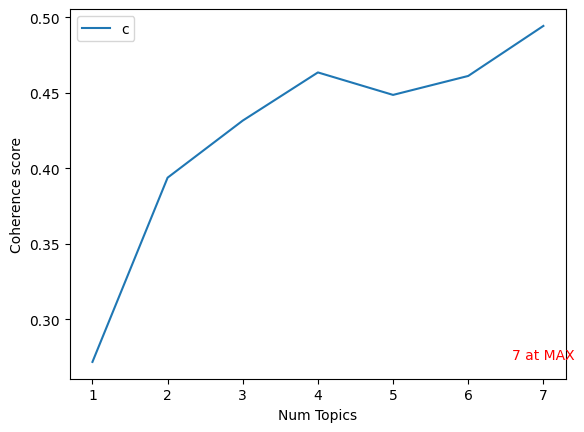

In [99]:
limit = 8
NUM_TOPICS = find_optimal_number_of_topics(dictionary, corpus, processed_data, limit)

In [100]:
K_all["ProcessedData"] = K_all["ProcessedData"].apply(' '.join)

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(K_all["ProcessedData"])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [101]:
# LDA모델 생성
lda_model = LatentDirichletAllocation(n_components=4, learning_method='online', random_state=42, max_iter=1)
lda_top = lda_model.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [102]:
# 단어 집합. 1,000개의 단어가 저장됨.
terms = vectorizer.get_feature_names_out()

def get_topics(components, feature_names, n=20):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n - 1:-1]])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [103]:
def get_topics2(components, terms):
    topics = []
    for topic_idx, topic in enumerate(components):
        topic_terms = [(terms[i], topic[i]) for i in topic.argsort()[:-30 - 1:-1]]
        topics.append((topic_idx, topic_terms))
    return topics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [104]:
K_all_topics = get_topics2(lda_model.components_, terms)
if K_all_topics is not None:
    df = pd.DataFrame(K_all_topics, columns=['Topic', 'Terms'])
else:
    df = pd.DataFrame()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [105]:
topics_transformed = [(topic[0], word, value) for topic in K_all_topics for word, value in topic[1]]
df = pd.DataFrame(topics_transformed, columns=['Topic', 'Word', 'Value'])
df.to_csv("/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/K_all_topics.csv",index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


* A_all

In [106]:
dfs = []  # 用于存储每个文件的DataFrame

for file in files:
    if file.endswith(('A1.xlsx', 'A2.xlsx','A3.xlsx')):
        file_path = os.path.join(folder_path, file)
        df = pd.read_excel(file_path)
        dfs.append(df)

merged_df = pd.concat(dfs, ignore_index=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [107]:
# merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40250 entries, 0 to 40249
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   뉴스 식별자             40250 non-null  float64
 1   일자                 40250 non-null  int64  
 2   언론사                40250 non-null  object 
 3   기고자                37918 non-null  object 
 4   제목                 40250 non-null  object 
 5   통합 분류1             40250 non-null  object 
 6   통합 분류2             36475 non-null  object 
 7   통합 분류3             29552 non-null  object 
 8   사건/사고 분류1          6469 non-null   object 
 9   사건/사고 분류2          1393 non-null   object 
 10  사건/사고 분류3          467 non-null    object 
 11  인물                 32226 non-null  object 
 12  위치                 40204 non-null  object 
 13  기관                 40235 non-null  object 
 14  키워드                40250 non-null  object 
 15  특성추출(가중치순 상위 50개)  40250 non-null  object 
 16  본문                 402

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [108]:
merged_df.to_csv("/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/A_all.csv", index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [109]:
dfs = []  # 用于存储每个文件的DataFrame

for file in files:
    if file.endswith(('C1.xlsx', 'C2.xlsx')):
        file_path = os.path.join(folder_path, file)
        df = pd.read_excel(file_path)
        dfs.append(df)

merged_df = pd.concat(dfs, ignore_index=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [110]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34734 entries, 0 to 34733
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   뉴스 식별자             34734 non-null  float64
 1   일자                 34734 non-null  int64  
 2   언론사                34734 non-null  object 
 3   기고자                32707 non-null  object 
 4   제목                 34734 non-null  object 
 5   통합 분류1             34734 non-null  object 
 6   통합 분류2             31777 non-null  object 
 7   통합 분류3             26208 non-null  object 
 8   사건/사고 분류1          5492 non-null   object 
 9   사건/사고 분류2          1091 non-null   object 
 10  사건/사고 분류3          383 non-null    object 
 11  인물                 26675 non-null  object 
 12  위치                 34710 non-null  object 
 13  기관                 34718 non-null  object 
 14  키워드                34734 non-null  object 
 15  특성추출(가중치순 상위 50개)  34734 non-null  object 
 16  본문                 347

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [111]:
merged_df.to_csv("/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/C_all.csv", index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [113]:
dfs = []  # 用于存储每个文件的DataFrame

for file in files:
    if file.endswith(('Economic1.xlsx', 'Economic2.xlsx')):
        file_path = os.path.join(folder_path, file)
        df = pd.read_excel(file_path)
        dfs.append(df)

merged_df = pd.concat(dfs, ignore_index=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
merged_df.info()

In [115]:
merged_df.to_csv("/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/Economic_all.csv", index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [118]:
dfs = []  # 用于存储每个文件的DataFrame

for file in files:
    if file.endswith(('Eport1.xlsx', 'Export2.xlsx')):
        file_path = os.path.join(folder_path, file)
        df = pd.read_excel(file_path)
        dfs.append(df)

merged_df = pd.concat(dfs, ignore_index=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [119]:
# merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33110 entries, 0 to 33109
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   뉴스 식별자             33110 non-null  float64
 1   일자                 33110 non-null  int64  
 2   언론사                33110 non-null  object 
 3   기고자                31604 non-null  object 
 4   제목                 33110 non-null  object 
 5   통합 분류1             33110 non-null  object 
 6   통합 분류2             29859 non-null  object 
 7   통합 분류3             23865 non-null  object 
 8   사건/사고 분류1          4167 non-null   object 
 9   사건/사고 분류2          822 non-null    object 
 10  사건/사고 분류3          278 non-null    object 
 11  인물                 22932 non-null  object 
 12  위치                 31857 non-null  object 
 13  기관                 32972 non-null  object 
 14  키워드                33110 non-null  object 
 15  특성추출(가중치순 상위 50개)  33110 non-null  object 
 16  본문                 331

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [120]:
merged_df.to_csv("/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/Ex_all.csv", index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [123]:
A_all=pd.read_csv('/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/A_all.csv')
C_all=pd.read_csv('/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/C_all.csv')
Ex_all=pd.read_csv('/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/Ex_all.csv')
Economic_all=pd.read_csv('/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/Economic_all.csv')



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [124]:
A_all=A_all.rename(columns={'본문':'Contents'})
C_all=C_all.rename(columns={'본문':'Contents'})
Ex_all=Ex_all.rename(columns={'본문':'Contents'})
Economic_all=Economic_all.rename(columns={'본문':'Contents'})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [126]:
dataframes = [A_all, C_all, Ex_all, Economic_all]
names = ['A_all', 'C_all', 'Ex_all', 'Economic_all']

for name, df in zip(names, dataframes):
    print(f"{name}: {len(df)}")

A_all: 40250
C_all: 34734
Ex_all: 33110
Economic_all: 36879


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [127]:
TARGET_COL = "Contents"
PROCESSED_COL = "ProcessedData"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [128]:
C_all[PROCESSED_COL]=[False for _ in range(len(C_all[TARGET_COL]))]
A_all[PROCESSED_COL]=[False for _ in range(len(A_all[TARGET_COL]))]
Ex_all[PROCESSED_COL]=[False for _ in range(len(Ex_all[TARGET_COL]))]
Economic_all[PROCESSED_COL]=[False for _ in range(len(Economic_all[TARGET_COL]))]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [129]:
C_all=C_all[["Contents","ProcessedData"]]
A_all=A_all[["Contents","ProcessedData"]]
Ex_all=Ex_all[["Contents","ProcessedData"]]
Economic_all=Economic_all[["Contents","ProcessedData"]]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [133]:
# C_all.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Contents,ProcessedData
0,올 들어 이달 20일까지 338억4000만달러의 무역적자가 났다. 연간 기준 역대 ...,올 들어 이달 20일까지 338억4000만달러의 무역적자가 났다. 연간 기준 역대 ...
1,미 중 갈등이 격화하는 가운데 중국의 미국 유럽 상대 수출은 크게 감소한 반면 러시...,미 중 갈등이 격화하는 가운데 중국의 미국 유럽 상대 수출은 크게 감소한 반면 러시...
2,"[머니투데이 송지유 기자] [루치르 샤르마 회장, 파이낸셜타임스에 기고문 \n""인구...","[머니투데이 송지유 기자] [루치르 샤르마 회장, 파이낸셜타임스에 기고문 ""인구 ..."
3,"1980년대 제3세계 국가에서나 벌어질 법한 일이 2022년 유럽, 그것도 세계 5...","1980년대 제3세계 국가에서나 벌어질 법한 일이 2022년 유럽, 그것도 세계 5..."
4,'시진핑(習近平) 3기로 인한 '차이나런'의 불똥이 원화로 튀었다. 25일 원화가치...,'시진핑(習近平) 3기로 인한 '차이나런'의 불똥이 원화로 튀었다. 25일 원화가치...


In [130]:
for i in range(len(C_all[TARGET_COL])):
    C_all[PROCESSED_COL][i] = remove_CRLF(C_all[TARGET_COL][i])

for i in range(len(A_all[TARGET_COL])):
    A_all[PROCESSED_COL][i] = remove_CRLF(A_all[TARGET_COL][i])

for i in range(len(Ex_all[TARGET_COL])):
    Ex_all[PROCESSED_COL][i] = remove_CRLF(Ex_all[TARGET_COL][i])

for i in range(len(Economic_all[TARGET_COL])):
    Economic_all[PROCESSED_COL][i] = remove_CRLF(Economic_all[TARGET_COL][i])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [131]:
#简写的代码
dfs = [C_all, A_all, Ex_all, Economic_all]

for df in dfs:
    for i in range(len(df[TARGET_COL])):
        df.at[i, PROCESSED_COL] = remove_CRLF(df.at[i, TARGET_COL])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dfs = [C_all, A_all, Ex_all, Economic_all]
names = ['C_all', 'A_all', 'Ex_all', 'Economic_all']

for df, name in zip(dfs, names):
    for i in range(len(df[TARGET_COL])):
        df.at[i, PROCESSED_COL] = remove_CRLF(df.at[i, TARGET_COL])

    # 각 DataFrame의 상위 5줄 출력
    print(f"{name}의 상위 5줄:")
    print(df.head())
    print("\n")


In [135]:
dfs = [C_all, A_all, Ex_all, Economic_all]

# 첫 번째 단계: 텍스트 정제
for df in dfs:
    for i in range(len(df[TARGET_COL])):
        df.at[i, PROCESSED_COL] = cleansing(df.at[i, TARGET_COL])

# 두 번째 단계: 불용어 제거 (tqdm 사용)
from tqdm import tqdm

for df in dfs:
    for i in tqdm(range(len(df[TARGET_COL]))):
        df.at[i, PROCESSED_COL] = remove_stopwords(df.at[i, PROCESSED_COL])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 36879/36879 [00:20<00:00, 1781.79it/s]


In [136]:
def process_dataframe(df):
    for i in tqdm(range(len(df[TARGET_COL]))):
        # List of strings to single string
        if isinstance(df[PROCESSED_COL][i], list):
            input_string = ' '.join(df[PROCESSED_COL][i])
        else:
            input_string = df[PROCESSED_COL][i]
        df.at[i, PROCESSED_COL] = tokenize_and_filter(input_string)

# 각 DataFrame에 대해 처리 함수 호출
dataframes = [C_all, A_all, Ex_all, Economic_all]
for df in dataframes:
    process_dataframe(df)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 36879/36879 [00:18<00:00, 1948.10it/s]


In [ ]:
# 查看每个DataFrame的前几行
for df_name, df in zip(['C_all', 'A_all', 'Ex_all', 'Economic_all'], [C_all, A_all, Ex_all, Economic_all]):
    print(f"{df_name} DataFrame:\n")
    print(df.head())
    print("\n" + "="*50 + "\n")

In [138]:
base_path = "/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028"

for df_name, df in zip(['C_all', 'A_all', 'Ex_all', 'Economic_all'], [C_all, A_all, Ex_all, Economic_all]):
    file_name = f"{base_path}/{df_name}_processed.csv"
    df.to_csv(file_name, index=False)
    print(f"{df_name} DataFrame has been saved to {file_name}\n")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C_all DataFrame has been saved to /content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/C_all_processed.csv

A_all DataFrame has been saved to /content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/A_all_processed.csv

Ex_all DataFrame has been saved to /content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/Ex_all_processed.csv

Economic_all DataFrame has been saved to /content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/Economic_all_processed.csv



In [140]:
def compute_word_frequencies(df, column_name):
    all_words = []
    for text in df[column_name]:
        if isinstance(text, list):
            all_words.extend(text)
        else:
            all_words.extend(text.split())

    word_counts = Counter(all_words)
    word_counts_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])
    word_counts_sorted = word_counts_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

    return word_counts_sorted


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [141]:
dataframes = {"C_all": C_all, "A_all": A_all, "Ex_all": Ex_all, "Economic_all": Economic_all}
results = {}
for name, df in dataframes.items():
    results[name] = compute_word_frequencies(df, PROCESSED_COL)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for name, df in results.items():
    print(f"\n{name} Top Words:")
    print(df.head())

In [143]:
for name, df in results.items():
    file_name = f"{name}_word_counts.csv"  # 指定文件名
    full_save_path = f"{base_path}/{file_name}"

    df.to_csv(full_save_path, index=False)  # 保存DataFrame为CSV文件
    print(f"Word counts for {name} saved to {full_save_path}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Word counts for C_all saved to /content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/C_all_word_counts.csv
Word counts for A_all saved to /content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/A_all_word_counts.csv
Word counts for Ex_all saved to /content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/Ex_all_word_counts.csv
Word counts for Economic_all saved to /content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/Economic_all_word_counts.csv


In [153]:
C_all_counts=pd.read_csv("/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/C_all_word_counts.csv")
A_all_counts=pd.read_csv("/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/A_all_word_counts.csv")
K_all_counts=pd.read_csv("/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/K_all_word_counts.csv")
Ex_all_counts=pd.read_csv("/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/Ex_all_word_counts.csv")
Economic_all_counts=pd.read_csv("/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/Economic_all_word_counts.csv")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dataframes_to_merge = [C_all_counts, K_all_counts, A_all_counts, Ex_all_counts, Economic_all_counts]
suffixes_list = ['_C', '_K', '_A', '_Ex', '_Economic']

merged_df = dataframes_to_merge[0]
for i in range(1, len(dataframes_to_merge)):
    merged_df = pd.merge(merged_df, dataframes_to_merge[i], on='Word', how='inner', suffixes=('', suffixes_list[i]))

# 创建一个新列来存放重复词的总频率
merged_df['Total_Frequency'] = merged_df.filter(regex='Frequency').sum(axis=1)

print(merged_df)

In [159]:
merged_df.to_csv('/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/rpeated_word_counts.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 토픽분석

In [162]:
C_all_p=pd.read_csv("/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/C_all_processed.csv")
A_all_p=pd.read_csv("/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/A_all_processed.csv")
Ex_all_p=pd.read_csv("/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/Ex_all_processed.csv")
Economic_all_p=pd.read_csv("/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/Economic_all_processed.csv")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [163]:
# C_all_p.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Contents,ProcessedData
0,올 들어 이달 20일까지 338억4000만달러의 무역적자가 났다. 연간 기준 역대 ...,"['이달', '달러', '무역', '적자', '연간', '기준', '역대', '최대..."
1,미 중 갈등이 격화하는 가운데 중국의 미국 유럽 상대 수출은 크게 감소한 반면 러시...,"['갈등', '격화', '가운데', '중국', '미국', '유럽', '수출', '감..."
2,"[머니투데이 송지유 기자] [루치르 샤르마 회장, 파이낸셜타임스에 기고문 \n""인구...","['송지유', '루치', '샤르마', '회장', '파이낸셜', '타임스', '인구'..."
3,"1980년대 제3세계 국가에서나 벌어질 법한 일이 2022년 유럽, 그것도 세계 5...","['세계', '국가', '유럽', '그것', '세계', '경제', '대국인', '영..."
4,'시진핑(習近平) 3기로 인한 '차이나런'의 불똥이 원화로 튀었다. 25일 원화가치...,"['시진핑', '차이', '불똥', '원화', '원화', '가치', '장중', '연..."


In [164]:
import ast

C_all_p["ProcessedData"] = C_all_p["ProcessedData"].apply(ast.literal_eval)

dictionary = corpora.Dictionary(C_all_p["ProcessedData"])

corpus = [dictionary.doc2bow(text) for text in C_all_p["ProcessedData"]]

processed_data = C_all_p["ProcessedData"].tolist()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


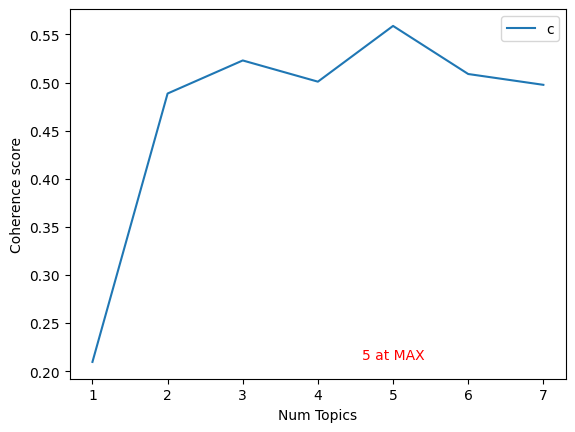

In [165]:
limit = 8
NUM_TOPICS = find_optimal_number_of_topics(dictionary, corpus, processed_data, limit)

In [166]:
C_all_p["ProcessedData"] = C_all_p["ProcessedData"].apply(' '.join)

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(C_all_p["ProcessedData"])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [169]:
# LDA모델 생성
lda_model = LatentDirichletAllocation(n_components=5, learning_method='online', random_state=42, max_iter=1)
lda_top = lda_model.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [170]:
def get_topics2(components, terms):
    topics = []
    for topic_idx, topic in enumerate(components):
        topic_terms = [(terms[i], topic[i]) for i in topic.argsort()[:-30 - 1:-1]]
        topics.append((topic_idx, topic_terms))
    return topics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [171]:
C_all_topics = get_topics2(lda_model.components_, terms)
if C_all_topics is not None:
    df = pd.DataFrame(C_all_topics, columns=['Topic', 'Terms'])
else:
    df = pd.DataFrame()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [172]:
topics_transformed = [(topic[0], word, value) for topic in C_all_topics for word, value in topic[1]]
df = pd.DataFrame(topics_transformed, columns=['Topic', 'Word', 'Value'])
df.to_csv("/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/C_all_topics.csv",index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


* A_topic

In [173]:
import ast

A_all_p["ProcessedData"] = A_all_p["ProcessedData"].apply(ast.literal_eval)

dictionary = corpora.Dictionary(A_all_p["ProcessedData"])

corpus = [dictionary.doc2bow(text) for text in A_all_p["ProcessedData"]]

processed_data = A_all_p["ProcessedData"].tolist()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


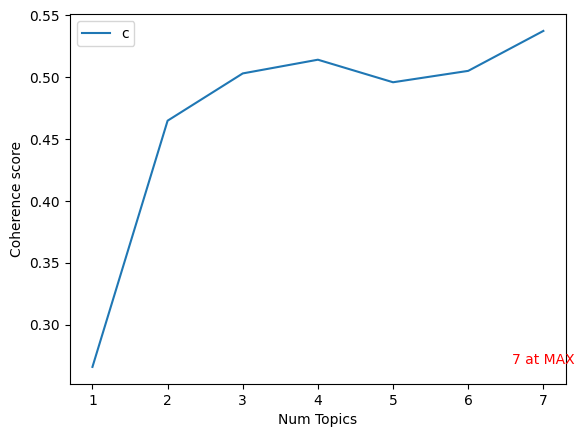

In [174]:
limit = 8
NUM_TOPICS = find_optimal_number_of_topics(dictionary, corpus, processed_data, limit)

In [175]:
A_all_p["ProcessedData"] = A_all_p["ProcessedData"].apply(' '.join)

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(A_all_p["ProcessedData"])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [176]:
# LDA모델 생성
lda_model = LatentDirichletAllocation(n_components=4, learning_method='online', random_state=42, max_iter=1)
lda_top = lda_model.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [177]:
A_all_topics = get_topics2(lda_model.components_, terms)
if A_all_topics is not None:
    df = pd.DataFrame(A_all_topics, columns=['Topic', 'Terms'])
else:
    df = pd.DataFrame()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [178]:
topics_transformed = [(topic[0], word, value) for topic in A_all_topics for word, value in topic[1]]
df = pd.DataFrame(topics_transformed, columns=['Topic', 'Word', 'Value'])
df.to_csv("/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/A_all_topics.csv",index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


* Export

In [179]:
import ast

Ex_all_p["ProcessedData"] = Ex_all_p["ProcessedData"].apply(ast.literal_eval)

dictionary = corpora.Dictionary(Ex_all_p["ProcessedData"])

corpus = [dictionary.doc2bow(text) for text in Ex_all_p["ProcessedData"]]

processed_data = Ex_all_p["ProcessedData"].tolist()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


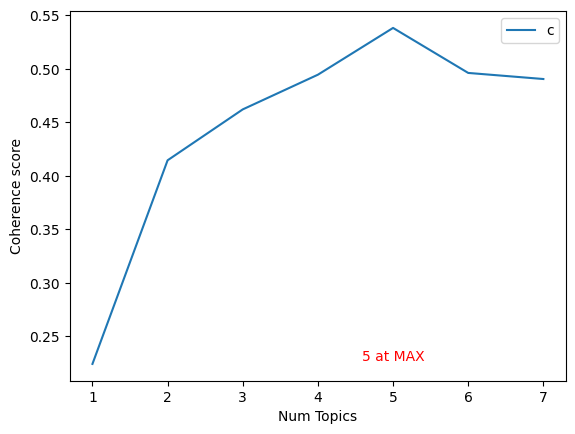

In [180]:
limit = 8
NUM_TOPICS = find_optimal_number_of_topics(dictionary, corpus, processed_data, limit)

In [181]:
Ex_all_p["ProcessedData"] = Ex_all_p["ProcessedData"].apply(' '.join)

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(Ex_all_p["ProcessedData"])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [182]:
# LDA모델 생성
lda_model = LatentDirichletAllocation(n_components=5, learning_method='online', random_state=42, max_iter=1)
lda_top = lda_model.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [183]:
Ex_all_topics = get_topics2(lda_model.components_, terms)
if Ex_all_topics is not None:
    df = pd.DataFrame(Ex_all_topics, columns=['Topic', 'Terms'])
else:
    df = pd.DataFrame()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [184]:
topics_transformed = [(topic[0], word, value) for topic in Ex_all_topics for word, value in topic[1]]
df = pd.DataFrame(topics_transformed, columns=['Topic', 'Word', 'Value'])
df.to_csv("/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/Ex_all_topics.csv",index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


* Economic

In [185]:
import ast

Economic_all_p["ProcessedData"] = Economic_all_p["ProcessedData"].apply(ast.literal_eval)

dictionary = corpora.Dictionary(Economic_all_p["ProcessedData"])

corpus = [dictionary.doc2bow(text) for text in Economic_all_p["ProcessedData"]]

processed_data = Economic_all_p["ProcessedData"].tolist()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


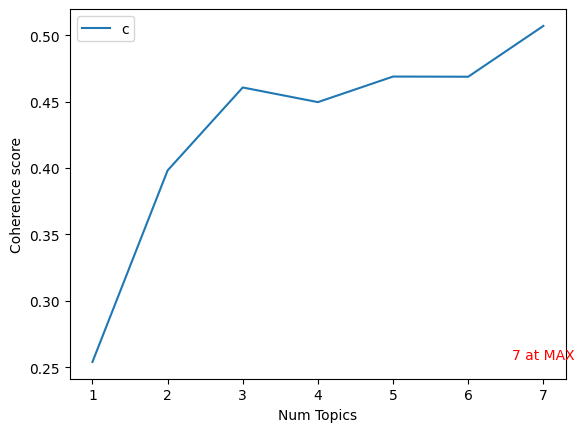

In [186]:
limit = 8
NUM_TOPICS = find_optimal_number_of_topics(dictionary, corpus, processed_data, limit)

In [187]:
Economic_all_p["ProcessedData"] = Economic_all_p["ProcessedData"].apply(' '.join)

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(Economic_all_p["ProcessedData"])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [188]:
# LDA모델 생성
lda_model = LatentDirichletAllocation(n_components=3, learning_method='online', random_state=42, max_iter=1)
lda_top = lda_model.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [189]:
Economic_all_topics = get_topics2(lda_model.components_, terms)
if Economic_all_topics is not None:
    df = pd.DataFrame(Economic_all_topics, columns=['Topic', 'Terms'])
else:
    df = pd.DataFrame()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [190]:
topics_transformed = [(topic[0], word, value) for topic in Economic_all_topics for word, value in topic[1]]
df = pd.DataFrame(topics_transformed, columns=['Topic', 'Word', 'Value'])
df.to_csv("/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028/Economic_all_topics.csv",index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [191]:
import matplotlib.pyplot as plt
import seaborn as sns


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


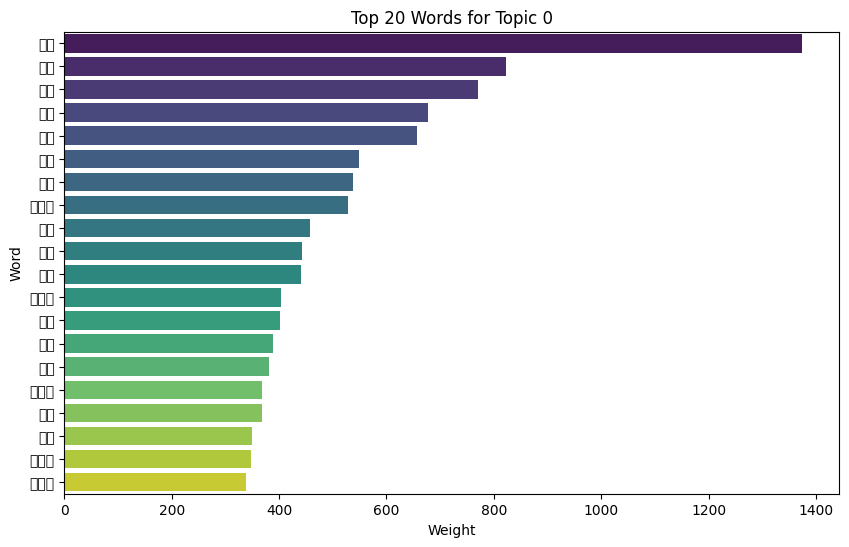

In [192]:
# 특정 토픽 선택 (예: Topic 0)
selected_topic = 0
topic_words = df[df['Topic'] == selected_topic]

# 상위 20개 키워드만 선택
top_20_words = topic_words.sort_values(by='Value', ascending=False).head(20)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Value', y='Word', data=top_20_words, palette="viridis")
plt.title(f'Top 20 Words for Topic {selected_topic}')
plt.xlabel('Weight')
plt.ylabel('Word')
plt.show()

# 코로나-경제

In [ ]:
folder_path = "/content/drive/MyDrive/최근/빅데이터/코로나와 무역/rawdata(20210101~20231026)_20231028"
files=os.listdir(folder_path)
files